# Phonon transport in Graphene

### Objective 1

Reproducing the DOS graphs in Ref "[Phonon transmission and thermal conductance across graphene/Cu interface](http://aip.scitation.org/doi/10.1063/1.4821439)"


### Geometry script
```tcl
package require nanotube
package require topotools

set molname graphene

graphene -lx 5 -ly 5 -type zigzag -b 0
set sel [atomselect top all]
$sel moveby {0.7090 0.0 0.0}
$sel writepdb $molname.pdb
$sel writepsf $molname.psf
topo writelammpsdata $molname.lmpsys

set mm [measure minmax $sel]
set xlo [format %.4f [expr [lindex $mm 0 0]+0.0] ]
set xhi [format %.4f [expr [lindex $mm 1 0]+1.4200] ]; # very imp
set ylo [format %.4f [expr [lindex $mm 0 1]+0.0] ]
set yhi [format %.4f [expr [lindex $mm 1 1]+1.2298] ]; # very imp
set zlo [format %.4f [expr [lindex $mm 0 2]-1.0] ]
set zhi [format %.4f [expr [lindex $mm 1 2]+1.0] ]

exec sed -i "12s/.*/  $xlo $xhi  xlo xhi/" $molname.lmpsys
exec sed -i "13s/.*/  $ylo $yhi  ylo yhi/" $molname.lmpsys
exec sed -i "14s/.*/  $zlo $zhi  zlo zhi/" $molname.lmpsys

exec rm -f $molname.pdb
mol delete all
exit
```

### Graphene Geometry



![Graphene](https://rawgit.com/abhijithanandan/the-phonon-project/master/Graphene.png)

### Specs

No. of atoms | Type | n x m
:---: | :---: | :---:
1008 | zigzag | 5 x 5

### Lammps Code
```lammps
units		real
atom_style	full
boundary	p p p
newton		on 

#----------------------------------------------------
#INPUT FILE
#----------------------------------------------------

read_data	inputFiles/graphene.lmpsys

#----------------------------------------------------
#GROUP
#----------------------------------------------------

group		g1 id 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

#----------------------------------------------------
#POTENTIAL
#----------------------------------------------------

pair_style 	rebo 	
pair_coeff 	* * inputFiles/CH.airebo.real C 

#----------------------------------------------------
#INITIALIZATION
#----------------------------------------------------

velocity       all create 300 1234567 mom yes rot yes 

#----------------------------------------------------
#NEIGHBOUR LIST
#----------------------------------------------------

neighbor	2.5 bin
neigh_modify	every 1 delay 0 check yes

#----------------------------------------------------
#FORCE
#----------------------------------------------------

variable	Fx equal fcm(all,x)
variable	Fy equal fcm(all,y)

#----------------------------------------------------
#LOG
#----------------------------------------------------

thermo_style    custom step temp pe ke etotal v_Fx v_Fy
thermo          100  
log             outputFiles/thermo.log

#----------------------------------------------------
#COMPUTE
#----------------------------------------------------

compute		c1 all temp

#----------------------------------------------------
#TIMESTEP
#----------------------------------------------------

timestep	1

#----------------------------------------------------
#NPT RUN
#----------------------------------------------------

fix		fxnpt all npt temp 300 300 100 iso 1.0 1.0 1000.0 

dump            dmpall all dcd 1000 outputFiles/graphene1.dcd   

run		100000

undump		dmpall

unfix		fxnpt


#----------------------------------------------------
#NVT RUN
#----------------------------------------------------

fix 		fxnvt all nvt temp 300.0 300.0 100.0
fix 		fxmom all momentum 1 linear 1 1 1 angular

#----------------------------------------------------
#EQUILIBRATION RUN
#----------------------------------------------------

dump            dmpall all dcd 1000 outputFiles/graphene2.dcd   

run 		100000

undump		dmpall

#----------------------------------------------------
#TEST RUN 
#----------------------------------------------------

#unfix		fxnvt
#fix		fxnve all nve 

#run 		500000

#unfix		fxnve
#fix		fxnvt all nvt temp 300.0  300.0 100.0

#----------------------------------------------------
#DUMP FILES
#----------------------------------------------------

dump            dmpvel g1 custom 6 outputFiles/velocity.dat id vx vy vz

dump            dmpall all dcd 1000 outputFiles/graphene3.dcd   

#----------------------------------------------------
#PRODUCTION RUN
#----------------------------------------------------

run 		1000000

```

<blockquote>
Now the temperature and energy values are extracted form log file of <b> lammps code #1 </b> and written to the file 'thermo.dat' using the following bash commands
</blockquote>

``` bash

awk 'NR>=33 && NR<=1032 {print $0}' thermo.log > thermo.dat
awk 'NR>=1087 && NR<=2086 {print $0}' thermo.log >> thermo.dat 
awk 'NR>=2150 && NR<=12150 {print $0}' thermo.log >> thermo.dat 

```

<blockquote>
The temperature and energy are plotted over time as follows:
</blockquote>

## Temperature vs Time

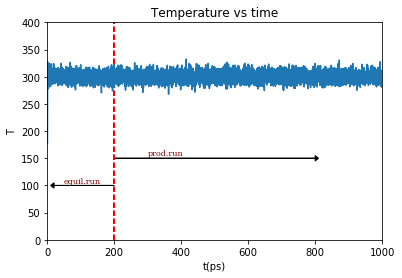

In [72]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 8,
        }

data = np.loadtxt("thermo.dat")
T = data[:,1]
t = data[:,0]
t = t/1000
plt.axvline(x=200, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.text(300, 155, r'prod.run', fontdict=font)
plt.text(50, 105, r'equil.run', fontdict=font)
ax = plt.axes()
ax.arrow(200, 150, 600, 0, head_width= 10, head_length= 10, fc='k', ec='k')
ax.arrow(200, 100, -180, 0, head_width= 10, head_length= 10, fc='k', ec='k')

plt.xlabel("t(ps)")
plt.axis([0,1000,0,400])
plt.ylabel("T")
plt.title("Temperature vs time")
plt.plot(t,T)
plt.show()

## Potential Energy vs time

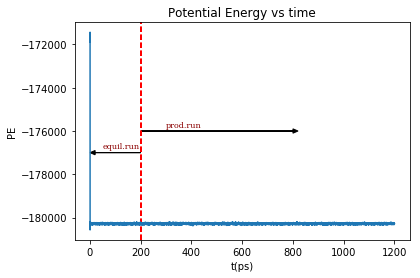

In [75]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 8,
        }

data = np.loadtxt("thermo.dat")
PE = data[:,2]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
plt.axvline(x=200, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.text(300, -175800, r'prod.run', fontdict=font)
plt.text(50, -176800, r'equil.run', fontdict=font)
ax = plt.axes()
ax.arrow(200, -176000, 600, 0, head_width= 200, head_length= 20, fc='k', ec='k')
ax.arrow(200, -177000, -180, 0, head_width= 200, head_length= 20, fc='k', ec='k')

plt.xlabel("t(ps)")
plt.ylabel("PE")
plt.title("Potential Energy vs time")
plt.plot(t,PE)
plt.show()

## Kinetic Energy vs time

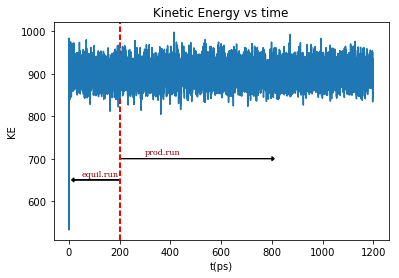

In [59]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 8,
        }

data = np.loadtxt("thermo.dat")
KE = data[:,3]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
#fig = plt.figure()
#ax = fig.add_subplot(111)
#line = ax.plot(t, KE)
#ax.annotate('', xy=(1000, 700), xytext=(200, 700),
#            arrowprops=dict(facecolor='black', shrink=0.05),)
            
plt.axvline(x=200, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
#plt.text(300, 750, r'$\cos(2 \pi t) \exp(-t)$', fontdict=font)
plt.text(300, 710, r'prod.run', fontdict=font)
plt.text(50, 660, r'equil.run', fontdict=font)
ax = plt.axes()
ax.arrow(200, 700, 600, 0, head_width= 10, head_length= 10, fc='k', ec='k')
ax.arrow(200, 650, -180, 0, head_width= 10, head_length= 10, fc='k', ec='k')

plt.xlabel("t(ps)")
plt.ylabel("KE")
plt.title("Kinetic Energy vs time")
plt.plot(t,KE)
plt.show()

## Total Energy vs Time

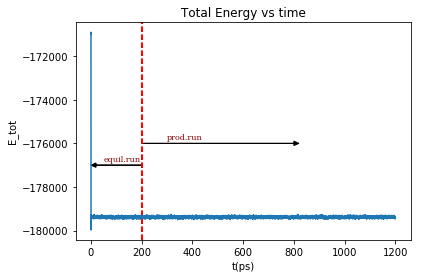

In [73]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 8,
        }

data = np.loadtxt("thermo.dat")
E = data[:,4]
t = data[:,0]
t = t/1000                                                          #converting time to ps 
plt.axvline(x=200, color = 'r', linewidth=2, linestyle='dashed')
#plt.axvline(x=1500, color = 'r', linewidth=2, linestyle='dashed')
plt.text(300, -175800, r'prod.run', fontdict=font)
plt.text(50, -176800, r'equil.run', fontdict=font)
ax = plt.axes()
ax.arrow(200, -176000, 600, 0, head_width= 200, head_length= 20, fc='k', ec='k')
ax.arrow(200, -177000, -180, 0, head_width= 200, head_length= 20, fc='k', ec='k')



plt.xlabel("t(ps)")
plt.ylabel("E_tot")
plt.title("Total Energy vs time")
plt.plot(t,E)
plt.show()

<blockquote>
<b> The Force Fx and Fy are found almost zero in log file and hence it's assumed that there is no stress acting on the body. </b>
</blockquote>

## Post Processing


<blockquote>
The velocity file <b>vel.dat</b> is obtained and it is sorted and spereate velocity files are written for each atom using the following <b>bash</b> script:
</blockquote>



```bash
awk '/ITEM: ATOMS/,/ITEM: TIMESTEP/' velocity.dat > tmp.dat
sed -i '/ITEM/d' tmp.dat
mv tmp.dat vel.dat

sort -n -k1 vel.dat > velSorted.dat

awk 'NR%166667==0{print $1}' velSorted.dat > ids.dat     #Since data collected every 6 steps for 1000000 steps
        
i=1
num=1
while [ ${num} ]; 
do
        awk '$1=='${num}'{print $0}' velSorted.dat > velxyz.tmp
        awk '{r=($2*$2+$3*$3+$4*$4)**0.5;}{printf"%d %0.20f %0.20f %0.20f %0.20f\n",$1,$2,$3,$4,r;}' velxyz.tmp > vel.tmp
        cp vel.tmp vel${num}.txt
        echo done $num 
        rm -f *.tmp
        num=$(sed "${i}q;d" ids.dat)
        i=$(($i+1))
done
```


<blockquote>

Once the velocity files are obtained from <b>lammps code #2</b> the following python script is used to calculate DOS from eqn:
</blockquote>


$$ DOS = fft \langle V \bigodot V \rangle $$

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


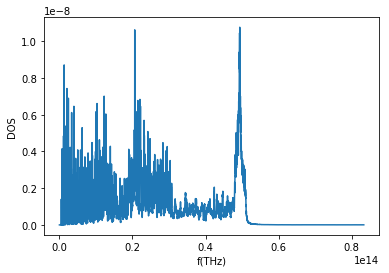

array([  3.43089519e-11,   1.92385472e-11,   2.70539847e-11, ...,
         3.03070816e-11,   2.70539847e-11,   1.92385472e-11])

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import scikits.talkbox.tools as tl
ids = np.loadtxt("ids.dat")

tsteps = 166667
nvel = 10000
count = tsteps/nvel
n = 2**tl.nextpow2(nvel)
Dsum = 0
natoms = 15
Dt = 1
for j in range(count):
    Dx = 0
    Dy = 0
    Dz = 0
    for i in ids:
        val = int(i)
        fname = "vel"+str(val)+".txt"
        data = np.loadtxt(fname)
        Vx = data[nvel*(j):nvel*(j+1)-1,1]
        Vy = data[nvel*(j):nvel*(j+1)-1,2]
        Vz = data[nvel*(j):nvel*(j+1)-1,3]
        Dxsum = np.fft.fft(Vx,n)
        Dx = Dx + np.abs(Dxsum/n)**2
        Dysum = np.fft.fft(Vy,n)
        Dy = Dy + np.abs(Dysum/n)**2
        Dzsum = np.fft.fft(Vz,n)
        Dz = Dz + np.abs(Dzsum/n)**2
    print j   
    D = (Dx+Dy+Dz)/3/natoms
    Dsum = Dsum + D

DOS = Dsum/count
N = np.size(Dsum)
DOS = DOS[:N/2]
freq = np.fft.fftfreq(N,d = 6e-15)
freq = freq
freq = freq[:N/2]
#freq = (1/(n*Dt*1e-15))*((0:np.size(DOS)-1)/1e15)
plt.xlabel("f(THz)")
plt.ylabel("DOS")
plt.plot(freq,DOS)
plt.show()
Dsum

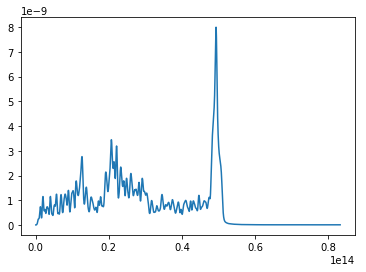

In [99]:
from pwtools import signal
import scipy

a = signal.smooth(DOS, scipy.signal.hann(80))
plt.plot(freq,a)
plt.show()

The results are also analysed with the welch funcion method described in "[The use of FFT for estimation of power spectra. A method based on time averaging over short modified Periodograms](https://www.utd.edu/~cpb021000/EE%204361/Great%20DSP%20Papers/Welchs%20Periodogram.pdf)"

For the purpose the following bash and python codes are used:

```bash

cd ../

mkdir dos dosx dosy dosz

cp ./outputFiles/velocity.dat ./dos/
cp ./analysis_scripts/split.sh ./dos/

cd ./dos/
./split.sh

cd ../

cp ./dos/ids.dat ./dosx/
cp ./dos/ids.dat ./dosy/
cp ./dos/ids.dat ./dosz/

cp ./analysis_scripts/dos.py ./dosx/
cp ./analysis_scripts/dos.py ./dosy/
cp ./analysis_scripts/dos.py ./dosz/

sed -i "6d" ./dosx/dos.py
sed -i "6i vel = vel[:,1]" ./dosx/dos.py

sed -i "6d" ./dosy/dos.py
sed -i "6i vel = vel[:,2]" ./dosy/dos.py

sed -i "6d" ./dosz/dos.py
sed -i "6i vel = vel[:,3]" ./dosz/dos.py

cp ./dos/vel*.txt ./dosx/
cp ./dos/vel*.txt ./dosy/
cp ./dos/vel*.txt ./dosz/

cp ./analysis_scripts/dos.sh ./dosx/
cp ./analysis_scripts/dos.sh ./dosy/
cp ./analysis_scripts/dos.sh ./dosz/

cp ./analysis_scripts/avg_dos.sh ./dosx/
cp ./analysis_scripts/avg_dos.sh ./dosy/
cp ./analysis_scripts/avg_dos.sh ./dosz/

cd ./dosx/
./dos.sh
./avg_dos.sh
cd ../

cd ./dosy/
./dos.sh
./avg_dos.sh
cd ../

cd ./dosz/
./dos.sh
./avg_dos.sh
cd ../

cp ./dosx/Pxx_avg.dat ./dos/dosx.dat
cp ./dosy/Pxx_avg.dat ./dos/dosy.dat
cp ./dosz/Pxx_avg.dat ./dos/dosz.dat

cp ./analysis_scripts/avg.sh ./dos/

cp ./dosx/freq.dat ./dos/

cd ./dos/
./avg.sh

mkdir analysis

mv dos ./analysis/
mv dosx ./analysis/
mv dosy ./analysis/
mv dosz ./analysis/
```
The python codes used in above script:


```python
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

vel = np.loadtxt('vel.tmp')
vel = vel[:,1]
corr = np.correlate(vel,vel,mode='full')
N = np.size(corr)
corr = corr[:N/2]
f, Pxx_den = signal.welch(corr,fs=1.0,window='hamming',nperseg=5000,noverlap=2500,nfft=10000,detrend='constant', return_onesided=True)
np.savetxt("Pxx.tmp",Pxx_den)
np.savetxt("freq.dat",f)
```

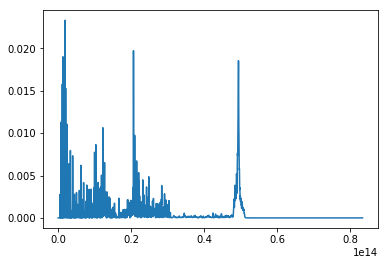

In [100]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("dos.dat")
DOS = data[:,1]
freq = data[:,0]*(1/6e-15)
plt.plot(freq,DOS)
plt.show()

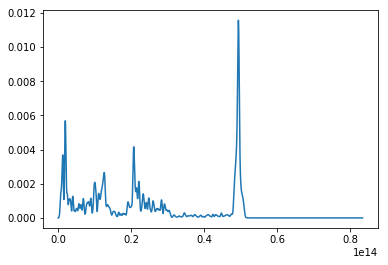

In [101]:
from pwtools import signal
import scipy

a = signal.smooth(DOS, scipy.signal.hann(50))
plt.plot(freq,a)
plt.show()

### Pwtools Pydos

The analysis is also done with the pwtools pydos package documented [here](http://elcorto.github.io/pwtools/written/background/phonon_dos.html#module-pwtools.pydos):

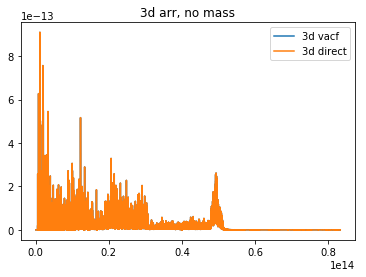

In [80]:
import os
import shutil
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.fftpack import fft
from pwtools import pydos, constants, common, num, signal, crys


dt = 6e-15
time_axis = 0
nstep = 166667
natoms = 15
arr= np.empty((nstep, natoms, 3))
for i in range(natoms):
    datafile = 'vel'+str(i+1)+'.txt'
    veldata = np.loadtxt(datafile)
    for k in range(3):
        arr[:,i,k] = veldata[:,k+1]

M = None
f4, y4n = pydos.vacf_pdos(arr, dt=dt, m=M, mirr=True)
f5, y5n = pydos.direct_pdos(arr, dt=dt, m=M)


figs = []
axs = []
    
figs.append(plt.figure())
axs.append(figs[-1].add_subplot(111))
axs[-1].set_title('3d arr, no mass')
axs[-1].plot(f4, y4n, label='3d vacf')
axs[-1].plot(f5, y5n, label='3d direct')
axs[-1].legend()
 
plt.show()

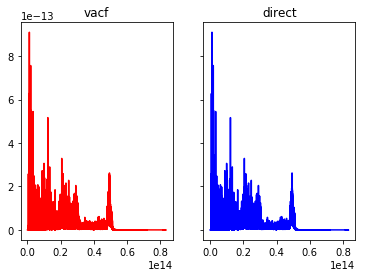

In [97]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows =1, ncols=2, sharey=True)
ax0.set_title('vacf')
ax0.plot(f4, y4n, 'r')

ax1.set_title('direct')
ax1.plot(f5, y5n, 'b')
plt.show()